<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807537 entries, 0 to 807536
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ts                 807537 non-null  datetime64[ns]
 1   id_orig_h          807537 non-null  object        
 2   id_resp_p          807537 non-null  int64         
 3   response_body_len  807537 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 24.6+ MB
None
                               ts      id_orig_h  id_resp_p  response_body_len
0      2012-05-30 19:09:27.177343  192.168.88.10         80               4910
1      2012-05-30 19:09:28.343725  192.168.88.10         80               3250
2      2012-05-30 19:09:29.124170  192.168.88.10         80                373
3      2012-05-30 19:09:29.142869  192.168.88.10         80              46495
4      2012-05-30 19:09:29.602005  192.168.88.10         80               8771
...  

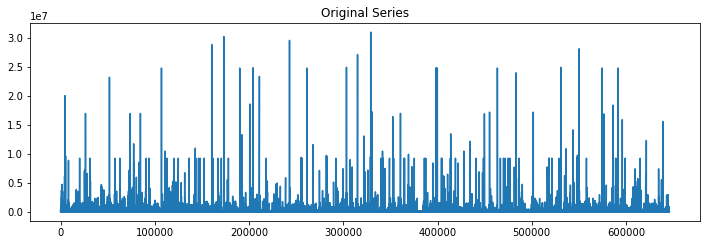

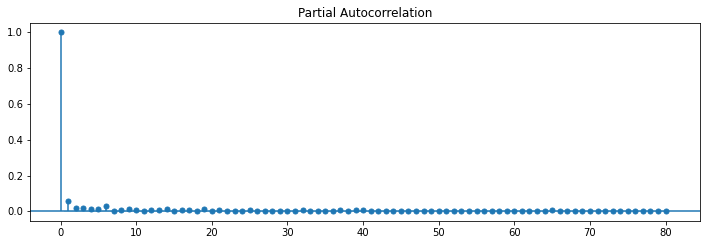

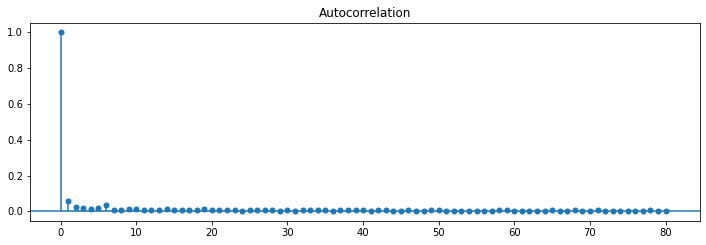


Tiempo del proceso ---> 5.847666666666667m


In [1]:
from time import time
from os import listdir
from pandas import read_parquet, read_csv, DataFrame
from datetime import datetime as dt
from modules import  run_arima

def log_to_parquet(in_file: str, out_file: str, file_cols: list, parquet_engine: str):
    # LOAD DATA FROM A LOG FILE AND SAVE IT ON A PARQUET FILE TO IMPROVE PERFORMANCE AT READING THE DATA
    df = read_csv(in_file, sep="\t", header=None,
                  names=file_cols, low_memory=False)
    df.to_parquet(out_file, index=False, engine=parquet_engine)
    del df


def get_files_inFolder(folder: str, fileType: str):
    return list(filter(lambda fileName: 
                            fileName[-len(fileType):] == fileType,
                        listdir(folder)))


def slice_dataFrame(df: DataFrame, slice_size: float):
    idx_cut = int((df.shape[0])*(1-slice_size))
    return df.iloc[:idx_cut], df.iloc[idx_cut:]


def an_detect(http_log_name: str):
    P_ENGINE = "pyarrow"
    TEST_SIZE = 0.2
    cols_log = ['ts', 'uid', 'id_orig_h', 'id_orig_p', 'id_resp_h', 'id_resp_p',
                'trans_depth', 'method', 'host', 'uri', 'referrer', 'user_agent',
                'request_body_len', 'response_body_len', 'status_code', 'status_msg',
                'info_code', 'info_msg', 'filename', 'tags', 'username',
                'password', 'proxied', 'orig_fuids', 'orig_mime_types', 'resp_fuids',
                'resp_mime_types']
    list_parq_files = get_files_inFolder("./","parq")
    http_parq_name = (http_log_name.split('.')[0])+".parq"
    if not http_parq_name in list_parq_files:
        log_to_parquet(http_log_name, http_parq_name, cols_log, P_ENGINE)
    
    important_cols = ["ts","id_orig_h", "id_resp_p", "response_body_len"]
    df = read_parquet(http_parq_name, columns=important_cols)
    df["ts"] = list(map(
                    lambda date: 
                        dt.fromtimestamp(float(date)),
                    df["ts"].tolist()))
    print(df.info())

    train_df, test_df = slice_dataFrame(df,TEST_SIZE)
    print(train_df)
    print(test_df)
    run_arima.get_pacf_acf(train_df,"response_body_len")



def main():
    paths = {
        "http":"http-1.log"
    }

    intiTime = time()

    an_detect(http_log_name=paths["http"])

    elapsedTime = round(time()-intiTime, 2)
    elapsedTime = str(elapsedTime/60) + \
        "m" if elapsedTime >= 60 else str(elapsedTime)+"s"
    print("\nTiempo del proceso --->", elapsedTime)


main()